In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fullok/problems/occlusion2_rec.svg
/kaggle/input/fullok/problems/frag1.svg
/kaggle/input/fullok/problems/occlusion1_rec.svg
/kaggle/input/fullok/problems/isolated_sol.csv
/kaggle/input/fullok/problems/occlusion2_sol_rec.svg
/kaggle/input/fullok/problems/occlusion1_sol_rec.png
/kaggle/input/fullok/problems/isolated_sol.svg
/kaggle/input/fullok/problems/frag2_sol.csv
/kaggle/input/fullok/problems/frag0.csv
/kaggle/input/fullok/problems/occlusion2_sol_rec.png
/kaggle/input/fullok/problems/occlusion2.svg
/kaggle/input/fullok/problems/occlusion1_sol.csv
/kaggle/input/fullok/problems/occlusion1.svg
/kaggle/input/fullok/problems/frag2.svg
/kaggle/input/fullok/problems/occlusion2_sol.csv
/kaggle/input/fullok/problems/isolated.svg
/kaggle/input/fullok/problems/occlusion1.csv
/kaggle/input/fullok/problems/frag0.svg
/kaggle/input/fullok/problems/frag2_sol.svg
/kaggle/input/fullok/problems/frag01_sol.csv
/kaggle/input/fullok/problems/occlusion1_sol_rec.svg
/kaggle/input/fullok/proble

In [2]:
oc1=pd.read_csv('/kaggle/input/fullok/problems/occlusion1.csv',header=None)
oc1.columns=['col1','col2','col3','col4']
oc2=pd.read_csv('/kaggle/input/fullok/problems/occlusion2.csv',header=None)
oc2.columns=['col1','col2','col3','col4']

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.special import comb

In [5]:
import numpy as np
from numpy.linalg import norm, lstsq

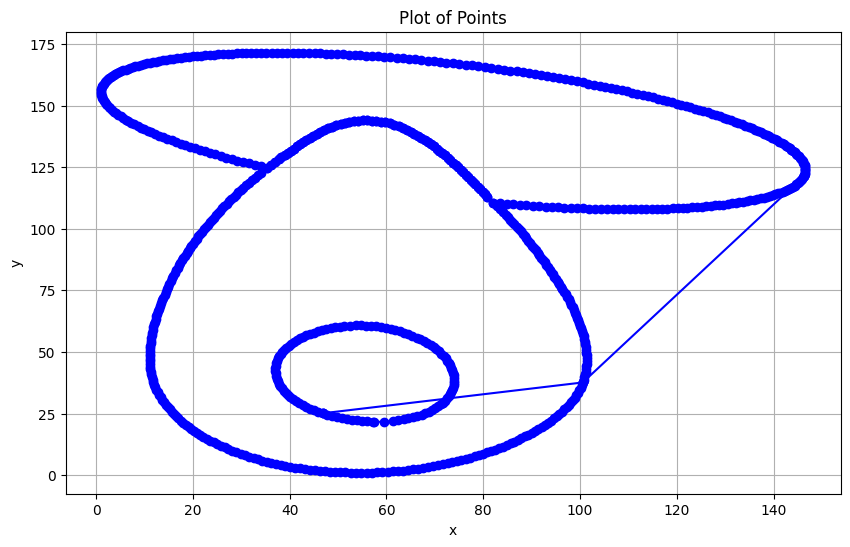

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(oc1['col3'], oc1['col4'], marker='o', linestyle='-', color='b')
plt.title('Plot of Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [7]:
ocs1=pd.read_csv('/kaggle/input/fullok/problems/occlusion1_sol.csv',header=None)
ocs1.columns=['col1','col2','col3','col4']
ocs2=pd.read_csv('/kaggle/input/fullok/problems/occlusion2_sol.csv',header=None)
ocs2.columns=['col1','col2','col3','col4']

In [8]:
value=oc2['col1'].value_counts().count()

In [9]:
ls=[]
for val in range(value):
    points=np.array(oc2[oc2['col1']==val][['col3','col4']])
    ls.append(points)

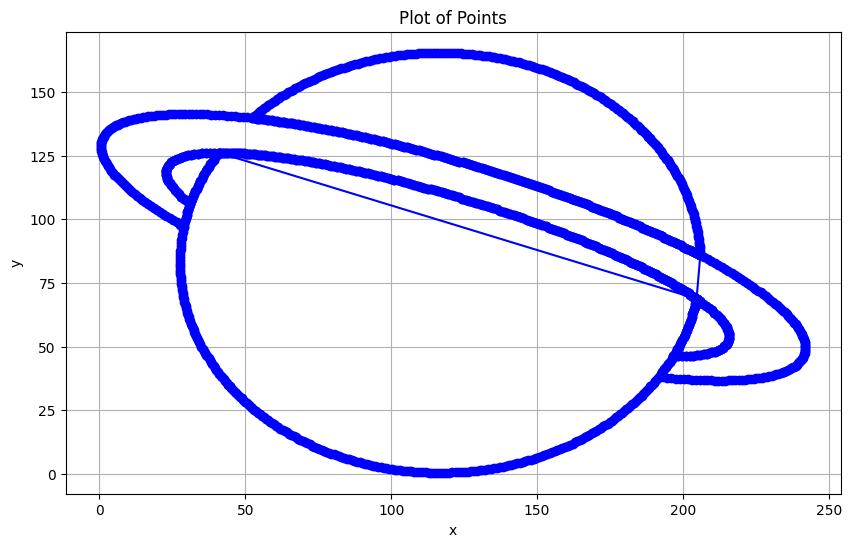

In [10]:
val=5
plt.figure(figsize=(10, 6))
plt.plot(oc2['col3'], oc2['col4'], marker='o', linestyle='-', color='b')
plt.title('Plot of Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

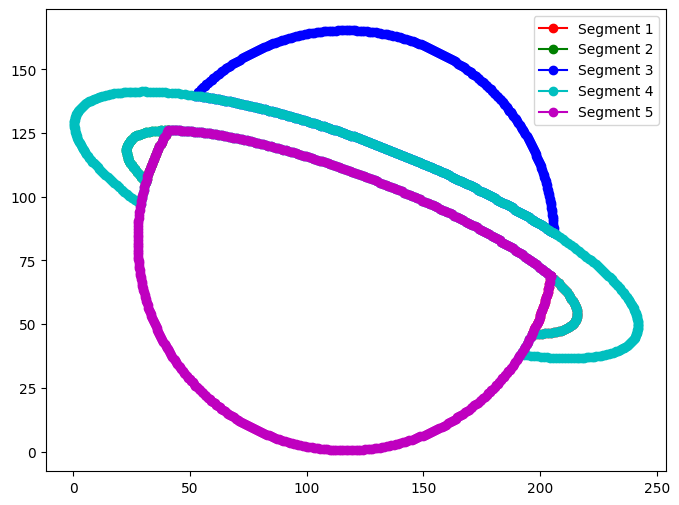

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations

def compute_curvature(segment):
    if len(segment) < 3:
        return 0
    p1, p2, p3 = segment[-3], segment[-2], segment[-1]
    ba = p1 - p2
    bc = p3 - p2
    cross_product = np.cross(ba, bc)
    norm_ba = np.linalg.norm(ba)
    norm_bc = np.linalg.norm(bc)
    curvature = np.linalg.norm(cross_product) / (norm_ba * norm_bc) if (norm_ba * norm_bc) != 0 else 0
    return curvature

def calculate_curvature_at_endpoints(segments):
    curvatures = []
    for segment in segments:
        curvature_start = compute_curvature(segment[:3])  # Start curvature
        curvature_end = compute_curvature(segment[-3:])   # End curvature
        curvatures.append((curvature_start, curvature_end))
    return curvatures

def construct_curvature_cost_matrix(segments, curvatures):
    n = len(segments)
    cost_matrix = np.zeros((n, n, 4))  # Consider reversed segments

    for i in range(n):
        for j in range(n):
            if i != j:
                c1_end = curvatures[i][1]
                c2_start = curvatures[j][0]
                c2_end = curvatures[j][1]
                c1_start = curvatures[i][0]
                
                # Calculate cost for different combinations of segment order and direction
                cost_matrix[i][j][0] = abs(c1_end - c2_start)  # Normal to normal
                cost_matrix[i][j][1] = abs(c1_start - c2_start)  # Reversed s1 to normal s2
                cost_matrix[i][j][2] = abs(c1_end - c2_end)  # Normal s1 to reversed s2
                cost_matrix[i][j][3] = abs(c1_start - c2_end)  # Reversed s1 to reversed s2

    return cost_matrix

def tsp_solver_curvature(cost_matrix):
    n = len(cost_matrix)
    min_cost = float('inf')
    best_sequence = None
    best_orientations = None

    # Generate all possible permutations of the segment indices
    for perm in permutations(range(n)):
        total_cost = 0
        orientations = []

        for i in range(len(perm) - 1):
            j, k = perm[i], perm[i+1]
            # Select the best connection considering all four possible orientations
            costs = cost_matrix[j][k]
            min_connection_cost = min(costs)
            orientation = np.argmin(costs)  # Get the best connection type
            
            total_cost += min_connection_cost
            orientations.append(orientation)
        
        # Update if this permutation has the minimum cost so far
        if total_cost < min_cost:
            min_cost = total_cost
            best_sequence = perm
            best_orientations = orientations
    
    return best_sequence, best_orientations

def reorder_segments(segments, best_sequence, best_orientations):
    reordered_segments = []

    for i, seg_idx in enumerate(best_sequence):
        segment = segments[seg_idx]

        # Make sure we don't access out of range indices
        if i < len(best_orientations) and best_orientations[i] in [1, 3]:  # If the segment is reversed
            segment = segment[::-1]
        
        reordered_segments.append(segment)

    return reordered_segments

def visualize_segments(segments):
    plt.figure(figsize=(8, 6))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Use different colors for different segments
    for i, segment in enumerate(segments):
        color = colors[i % len(colors)]
        plt.plot(segment[:, 0], segment[:, 1], color=color, marker='o', label=f'Segment {i+1}')
    
    plt.legend()
    plt.show()

# Define three segments of points (each segment is a list of [x, y] coordinates)
segment1 = np.array([[0.0, 0.0], [1.0, 2.0], [2.0, 4.0], [3.0, 6.0], [4.0, 8.0]])  # Almost a straight line
segment2 = np.array([[4.0, 8.0], [5.0, 9.0], [6.0, 10.0], [7.0, 8.0], [8.0, 6.0]])  # Curved downwards
segment3 = np.array([[8.0, 6.0], [7.0, 4.0], [6.0, 2.0], [5.0, 1.0], [4.0, 0.0]])   # Curved upwards

segments = ls

# Step 1: Calculate curvature at endpoints
curvatures = calculate_curvature_at_endpoints(segments)

# Step 2: Construct the curvature cost matrix
cost_matrix = construct_curvature_cost_matrix(segments, curvatures)

# Step 3: Solve the TSP with the curvature-based cost matrix
best_sequence, best_orientations = tsp_solver_curvature(cost_matrix)

# Step 4: Reorder the segments based on the TSP solution
reordered_segments = reorder_segments(segments, best_sequence, best_orientations)

# Output the reordered segments
visualize_segments(reordered_segments)


In [12]:
len(reordered_segments[4])

485

In [13]:
lcerchecker([reordered_segments[0]])

NameError: name 'lcerchecker' is not defined

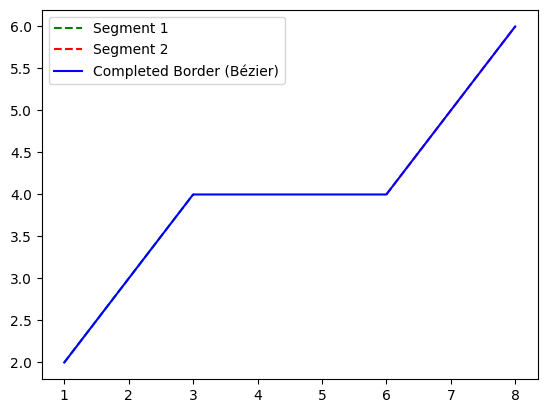

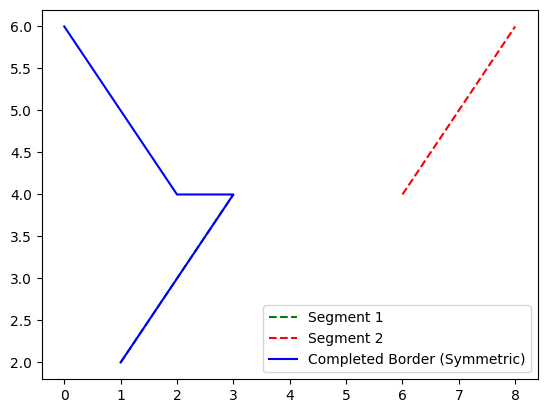

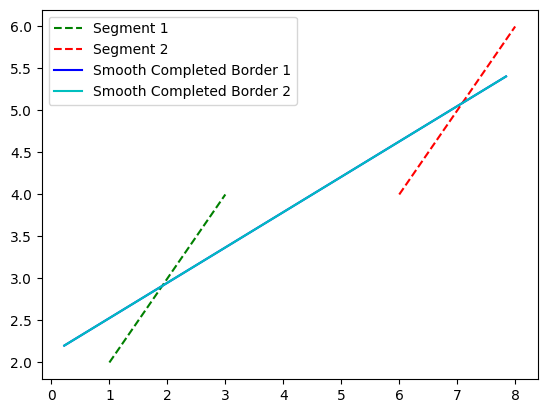

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline

def bezier_curve(t, P0, P1, P2, P3):
    """Compute the cubic Bézier curve."""
    return ((1-t)**3 * P0 +
            3 * (1-t)**2 * t * P1 +
            3 * (1-t) * t**2 * P2 +
            t**3 * P3)

def fit_bezier_curve(points):
    """Fit a cubic Bézier curve to the given points."""
    def cost(params):
        P0 = np.array(params[0:2])
        P1 = np.array(params[2:4])
        P2 = np.array(params[4:6])
        P3 = np.array(params[6:8])
        t = np.linspace(0, 1, len(points))
        curve = np.array([bezier_curve(ti, P0, P1, P2, P3) for ti in t])
        return np.sum((curve - points)**2)

    initial_params = np.concatenate([points[0], points[-1], np.mean(points, axis=0), np.mean(points, axis=0)])
    result = minimize(cost, initial_params, method='L-BFGS-B')
    P = np.array(result.x).reshape(4, 2)
    return P

def reflect_points(points, axis_point, axis_direction):
    """Reflect points across a symmetry axis."""
    reflected_points = []
    for point in points:
        vector = point - axis_point
        projection = np.dot(vector, axis_direction) * axis_direction
        reflected_point = 2 * projection - vector + axis_point
        reflected_points.append(reflected_point)
    return np.array(reflected_points)

def complete_border_bezier(segment1, segment2):
    """Complete the border using Bézier curves."""
    P1 = fit_bezier_curve(segment1)
    P2 = fit_bezier_curve(segment2)

    t = np.linspace(0, 1, 100)
    curve1 = np.array([bezier_curve(ti, *P1) for ti in t])
    curve2 = np.array([bezier_curve(ti, *P2) for ti in t])
    
    connection_curve_x = np.linspace(segment1[-1, 0], segment2[0, 0], 100)
    connection_curve_y = np.linspace(segment1[-1, 1], segment2[0, 1], 100)
    
    completed_border_x = np.concatenate([curve1[:, 0], connection_curve_x, curve2[:, 0]])
    completed_border_y = np.concatenate([curve1[:, 1], connection_curve_y, curve2[:, 1]])
    
    return completed_border_x, completed_border_y

def complete_border_symmetry(segment1, segment2, center, axis_direction):
    """Complete the border using symmetry."""
    reflected_segment2 = reflect_points(segment2, center, axis_direction)
    P1 = fit_bezier_curve(segment1)
    P2 = fit_bezier_curve(reflected_segment2)
    
    t = np.linspace(0, 1, 100)
    curve1 = np.array([bezier_curve(ti, *P1) for ti in t])
    curve2 = np.array([bezier_curve(ti, *P2) for ti in t])
    
    connection_curve_x = np.linspace(segment1[-1, 0], reflected_segment2[0, 0], 100)
    connection_curve_y = np.linspace(segment1[-1, 1], reflected_segment2[0, 1], 100)
    
    completed_border_x = np.concatenate([curve1[:, 0], connection_curve_x, curve2[:, 0]])
    completed_border_y = np.concatenate([curve1[:, 1], connection_curve_y, curve2[:, 1]])
    
    return completed_border_x, completed_border_y

def smooth_border_completion(segment1, segment2):
    """Optimize the completion of the border for smoothness."""
    def objective(params):
        t = np.linspace(0, 1, 100)
        P0 = params[0:2]
        P1 = params[2:4]
        P2 = params[4:6]
        P3 = params[6:8]
        
        curve1 = np.array([bezier_curve(ti, P0, P1, P2, P3) for ti in t])
        curve2 = np.array([bezier_curve(ti, P0, P1, P2, P3) for ti in t])
        
        curvature = np.diff(np.arctan2(np.diff(curve1[:, 1]), np.diff(curve1[:, 0])))
        return np.sum(curvature**2)
    
    initial_params = np.concatenate([segment1[0], segment2[-1], np.mean(segment1, axis=0), np.mean(segment2, axis=0)])
    result = minimize(objective, initial_params, method='L-BFGS-B')
    P = np.array(result.x).reshape(4, 2)
    
    t = np.linspace(0, 1, 100)
    curve1 = np.array([bezier_curve(ti, *P) for ti in t])
    curve2 = np.array([bezier_curve(ti, *P) for ti in t])
    
    return curve1, curve2

# Example usage
segment1 = np.array([[1, 2], [2, 3], [3, 4]])
segment2 = np.array([[6, 4], [7, 5], [8, 6]])

# Complete the border with Bézier curves
completed_x, completed_y = complete_border_bezier(segment1, segment2)

# Visualization for Bézier completion
plt.plot(segment1[:, 0], segment1[:, 1], 'g--', label='Segment 1')
plt.plot(segment2[:, 0], segment2[:, 1], 'r--', label='Segment 2')
plt.plot(completed_x, completed_y, 'b-', label='Completed Border (Bézier)')
plt.legend()
plt.show()

# Example usage with symmetry
center = np.array([4, 3])
axis_direction = np.array([0, 1])  # Vertical axis

completed_x_symmetry, completed_y_symmetry = complete_border_symmetry(segment1, segment2, center, axis_direction)

# Visualization for Symmetry completion
plt.plot(segment1[:, 0], segment1[:, 1], 'g--', label='Segment 1')
plt.plot(segment2[:, 0], segment2[:, 1], 'r--', label='Segment 2')
plt.plot(completed_x_symmetry, completed_y_symmetry, 'b-', label='Completed Border (Symmetric)')
plt.legend()
plt.show()

# Example usage for smooth completion
smooth_curve1, smooth_curve2 = smooth_border_completion(segment1, segment2)

# Visualization for Smooth completion
plt.plot(segment1[:, 0], segment1[:, 1], 'g--', label='Segment 1')
plt.plot(segment2[:, 0], segment2[:, 1], 'r--', label='Segment 2')
plt.plot(smooth_curve1[:, 0], smooth_curve1[:, 1], 'b-', label='Smooth Completed Border 1')
plt.plot(smooth_curve2[:, 0], smooth_curve2[:, 1], 'c-', label='Smooth Completed Border 2')
plt.legend()
plt.show()


In [16]:
def lcerchecker(segments):
#line , circle, ellipse, rectangle checker ............

    from scipy.special import comb
    import numpy as np
    from numpy.linalg import norm
    import matplotlib.pyplot as plt
    from matplotlib.patches import Ellipse, Rectangle

    def bezier_curve(t, points):
        """Calculate a point on a Bézier curve."""
        n = len(points) - 1
        return sum(comb(n, i) * (1 - t) ** (n - i) * t ** i * points[i] for i in range(n + 1))

    def distance_to_segment(p, v1, v2):
        """Calculate the distance from point p to the line segment (v1, v2)."""
        line_vec = v2 - v1
        p_vec = p - v1
        line_len = norm(line_vec)
        line_unitvec = line_vec / line_len
        projection = np.dot(p_vec, line_unitvec)
        if projection < 0:
            closest_point = v1
        elif projection > line_len:
            closest_point = v2
        else:
            closest_point = v1 + projection * line_unitvec
        return norm(p - closest_point)

    def fit_line(points):
        """Fit a line to the given points and return the error and model."""
        if len(points) < 2:
            return float('inf'), None
        X = points[:, 0].reshape(-1, 1)
        y = points[:, 1]
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        mse = np.mean((y - y_pred) ** 2)
        print("line",mse)
        return mse, model

    def fit_rectangle(points, iterations=100):
        """Iteratively fit a rectangle to the given points and return the error and vertices."""
        def rectangle_mse(vertices):
            def point_to_rect_distance(p, rect):
                """Calculate the minimum distance from a point to the edges of a rectangle."""
                x_min, y_min = rect[0]
                x_max, y_max = rect[2]
                distances = [
                    np.abs(p[0] - x_min),  # Left edge
                    np.abs(p[0] - x_max),  # Right edge
                    np.abs(p[1] - y_min),  # Bottom edge
                    np.abs(p[1] - y_max)   # Top edge
                ]
                return min(distances)

            distances = np.array([point_to_rect_distance(p, vertices) for p in points])
            return np.mean(distances ** 2)

        def compute_rectangle_corners(points):
            """Compute a rectangle that bounds the given points."""
            min_x, min_y = np.min(points, axis=0)
            max_x, max_y = np.max(points, axis=0)
            return np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y],
                [min_x, min_y]  # close the rectangle
            ])

        vertices = compute_rectangle_corners(points)

        for _ in range(iterations):
            # Perform iterative adjustment to vertices
            vertices += np.random.randn(*vertices.shape) * 0.01  # Random adjustments as a placeholder for gradient descent

        mse = rectangle_mse(vertices)

        # Plot the fitted rectangle
        plt.plot(*np.append(vertices, [vertices[0]], axis=0).T, label='Fitted Rectangle', color='green')
        print("recte",mse)
        return mse, vertices


    def fit_circle(points, iterations=100):
        """Iteratively fit a circle to the given points and return the error and parameters."""
        def circle_mse(center, radius):
            distances = np.array([norm(center - p) for p in points])
            return np.mean((distances - radius) ** 2)

        # Initial guess
        center = np.mean(points, axis=0)
        radius = np.mean([norm(center - p) for p in points])

        for _ in range(iterations):
            # Update radius
            distances = np.array([norm(center - p) for p in points])
            radius = np.mean(distances)

            # Update center
            distances_to_circle = distances - radius
            gradient = np.mean([2 * (center - p) * (distances_to_circle[i] / np.linalg.norm(center - p)) for i, p in enumerate(points)], axis=0)
            center -= 0.1 * gradient  # Adjust learning rate as needed

        mse = circle_mse(center, radius)

        # Plot the fitted circle
        circle = plt.Circle(center, radius, color='orange', fill=False, linestyle='--', label='Fitted Circle')
        plt.gca().add_patch(circle)
        print("circler",mse)
        return mse, (center, radius)


    def fit_ellipse(points, iterations=100):
        """Iteratively fit an ellipse to the given points and return the error and parameters."""

        def ellipse_mse(params, points):
            x0, y0, a, b, theta = params
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
            transformed_points = np.dot(points - [x0, y0], rotation_matrix)
            distances = (transformed_points[:, 0] / a) ** 2 + (transformed_points[:, 1] / b) ** 2
            mse = np.mean((distances - 1) ** 2)
            return mse
        x_mean, y_mean = np.mean(points, axis=0)
        a_guess = np.ptp(points[:, 0]) / 2
        b_guess = np.ptp(points[:, 1]) / 2
        initial_params = np.array([x_mean, y_mean, a_guess, b_guess, 0])

        for _ in range(iterations):
            # Optimize the ellipse parameters
            A = np.column_stack([
                points[:, 0]**2, 
                points[:, 0] * points[:, 1], 
                points[:, 1]**2, 
                points[:, 0], 
                points[:, 1], 
                np.ones_like(points[:, 0])
            ])
            B = np.ones_like(points[:, 0])
            fit_params, _, _, _ = lstsq(A, B, rcond=None)
            a_fit, b_fit, c_fit, d_fit, e_fit, f_fit = fit_params
            x0 = (b_fit * e_fit - 2 * c_fit * d_fit) / (4 * a_fit * c_fit - b_fit ** 2)
            y0 = (b_fit * d_fit - 2 * a_fit * e_fit) / (4 * a_fit * c_fit - b_fit ** 2)
            numerator = 2 * (a_fit * e_fit ** 2 + c_fit * d_fit ** 2 + f_fit * b_fit ** 2 - 2 * b_fit * d_fit * e_fit - a_fit * c_fit * f_fit)
            denominator1 = (b_fit ** 2 - 4 * a_fit * c_fit) * ((c_fit - a_fit) * np.sqrt(1 + 4 * b_fit ** 2 / ((a_fit - c_fit) ** 2)) - (c_fit + a_fit))
            denominator2 = (b_fit ** 2 - 4 * a_fit * c_fit) * ((a_fit - c_fit) * np.sqrt(1 + 4 * b_fit ** 2 / ((a_fit - c_fit) ** 2)) - (c_fit + a_fit))

            if denominator1 <= 0 or denominator2 <= 0:
                return float('inf'), (None, None, None, None, None)

            a = np.sqrt(numerator / denominator1)
            b = np.sqrt(numerator / denominator2)
            theta = 0.5 * np.arctan(b_fit / (a_fit - c_fit))

            params = np.array([x0, y0, a, b, theta])
            mse = ellipse_mse(params, points)
            initial_params = params
        ellipse = Ellipse((x0, y0), 2 * a, 2 * b, np.degrees(theta), fill=False, color='purple', linestyle='--', label='Fitted Ellipse')
        plt.gca().add_patch(ellipse)
        print("ellipse", mse)

        return mse, (x0, y0, a, b, theta)
    def bezier_curve(t, control_points):
        """Calculate the Bézier curve for a given set of control points and parameter t."""
        n = len(control_points) - 1
        return sum(comb(n, i) * (1 - t) ** (n - i) * t ** i * np.array(control_points[i]) for i in range(n + 1))

    def bezier_curve_error(params, points):
        """Calculate the MSE between the given points and the Bézier curve defined by the control points."""
        num_control_points = len(params) // 2
        control_points = np.array(params).reshape(num_control_points, 2)

        t = np.linspace(0, 1, len(points))
        bezier_points = np.array([bezier_curve(ti, control_points) for ti in t])

        distances = np.linalg.norm(points - bezier_points[:len(points)], axis=1)
        return np.mean(distances ** 2)



    def check_shape_fit(points, error_threshold=10.0):
        """Check which shapes fit the cluster and get errors."""
        errors = {}
        shapes = {
            'line': fit_line(points),
            'rectangle': fit_rectangle(points),
            'circle': fit_circle(points),
            'ellipse': fit_ellipse(points),
    #         'polygon': fit_polygon(points, num_sides=5)  # Example with 5 sides for a pentagon
        }

        for shape, (error, params) in shapes.items():
            if error <= error_threshold:
                errors[shape] = (error, params)
        return errors

    def plot_fitted_shapes(points, errors):
        """Plot the original points and fitted shapes."""
        plt.figure(figsize=(8, 8))

        # Plot original cluster points
        plt.scatter(points[:, 0], points[:, 1], label="Cluster Points", color="blue", marker='o')

        # Ensure that each shape is plotted with trial fits
        if 'line' in errors:
            error, model = errors['line']
            X = np.linspace(points[:, 0].min(), points[:, 0].max(), 100)
            y_pred = model.predict(X.reshape(-1, 1))
            plt.plot(X, y_pred, label=f'Fitted Line (Error: {error:.2f})', color="red")

        if 'rectangle' in errors:
            error, vertices = errors['rectangle']
            plt.plot(*np.append(vertices, [vertices[0]], axis=0).T, label=f'Fitted Rectangle (Error: {error:.2f})', color="green")

        if 'circle' in errors:
            error, (center, radius) = errors['circle']
            circle = plt.Circle(center, radius, color='orange', fill=False, linestyle='--', label=f'Fitted Circle (Error: {error:.2f})')
            plt.gca().add_patch(circle)

        if 'ellipse' in errors:
            error, params = errors['ellipse']
            x0, y0, a, b, theta = params
            ellipse = Ellipse((x0, y0), 2 * a, 2 * b, np.degrees(theta), fill=False, color='purple', linestyle='--', label=f'Fitted Ellipse (Error: {error:.2f})')
            plt.gca().add_patch(ellipse)

    

        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend(loc="best")
        plt.title("Shape Fitting Results")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()
    def reshape_segments_to_points(segments):
        """Reshape a list of segments where each segment is an array of [x, y] points into a single 2D numpy array."""
        points = np.concatenate(segments, axis=0)
        return points

    # Example usage
#     segments = [
#         im0,im1,im2,im4
#     ]
    # cluster_points=reshape_segments_to_points(segments)

    cluster_points = reshape_segments_to_points(segments)

    # Check which shapes fit the cluster and get errors
    shape_fit_errors = check_shape_fit(cluster_points, error_threshold=40)

    # Print the shape fitting errors
#     print("Shape Fit Errors:")
#     for shape, (error, params) in shape_fit_errors.items():
#         print(f"{shape.capitalize()}: Error = {error}, Params = {params}")

    # Plot the original cluster points and fitted shapes
    plot_fitted_shapes(cluster_points, shape_fit_errors)
    return shape_fit_errors
    

line 1808.3365588396287
recte 187.64538684656978
circler 163.36234736330232


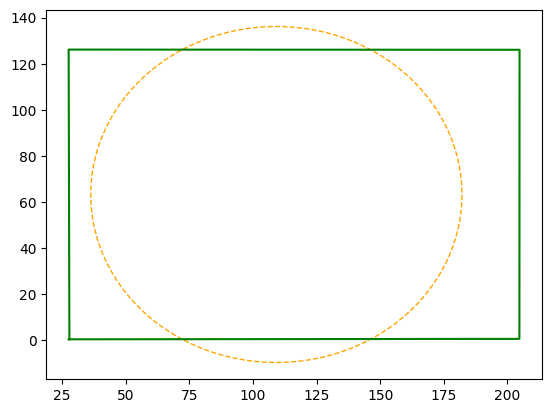

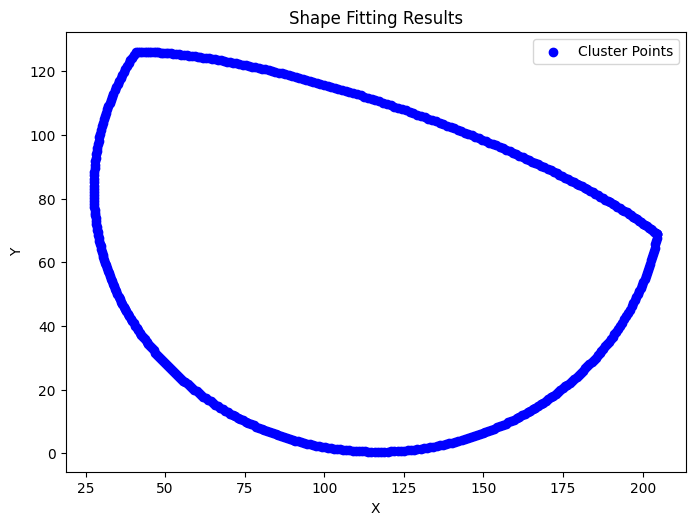

{}

In [17]:
lcerchecker([reordered_segments[4]])

In [ ]:
curvedsegme

/tmp/ipykernel_33/2724790091.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  cost_matrix[i][j][0] = abs(c1_end - c2_start) / (len1 + len2)  # Normal to normal
/tmp/ipykernel_33/2724790091.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  cost_matrix[i][j][1] = abs(c1_start - c2_start) / (len1 + len2)  # Reversed s1 to normal s2
/tmp/ipykernel_33/2724790091.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  cost_matrix[i][j][2] = abs(c1_end - c2_end) / (len1 + len2)  # Normal s1 to reversed s2
/tmp/ipykernel_33/2724790091.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  cost_matrix[i][j][3] = abs(c1_start - c2_end) / (len1 + len2)  # Reversed s1 to reversed s2


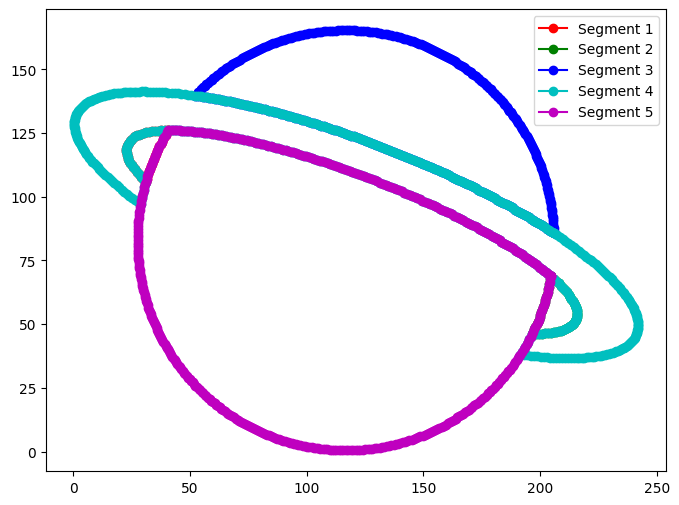

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
import random

def compute_curvature(segment):
    if len(segment) < 3:
        return 0
    curvatures = []
    for i in range(len(segment) - 2):
        p1, p2, p3 = segment[i], segment[i+1], segment[i+2]
        ba = p1 - p2
        bc = p3 - p2
        cross_product = np.cross(ba, bc)
        norm_ba = np.linalg.norm(ba)
        norm_bc = np.linalg.norm(bc)
        curvature = np.linalg.norm(cross_product) / (norm_ba * norm_bc) if (norm_ba * norm_bc) != 0 else 0
        curvatures.append(curvature)
    return np.mean(curvatures)

def calculate_curvature_at_endpoints(segments):
    curvatures = []
    for segment in segments:
        curvature_start = compute_curvature(segment[:3])  # Start curvature
        curvature_end = compute_curvature(segment[-3:])   # End curvature
        curvatures.append((curvature_start, curvature_end))
    return curvatures

def construct_curvature_cost_matrix(segments, curvatures):
    n = len(segments)
    cost_matrix = np.zeros((n, n, 4))  # Consider reversed segments

    for i in range(n):
        for j in range(n):
            if i != j:
                c1_end = curvatures[i][1]
                c2_start = curvatures[j][0]
                c2_end = curvatures[j][1]
                c1_start = curvatures[i][0]
                
                # Include segment lengths in cost calculation
                len1 = np.linalg.norm(segments[i][-1] - segments[i][0])
                len2 = np.linalg.norm(segments[j][-1] - segments[j][0])
                
                cost_matrix[i][j][0] = abs(c1_end - c2_start) / (len1 + len2)  # Normal to normal
                cost_matrix[i][j][1] = abs(c1_start - c2_start) / (len1 + len2)  # Reversed s1 to normal s2
                cost_matrix[i][j][2] = abs(c1_end - c2_end) / (len1 + len2)  # Normal s1 to reversed s2
                cost_matrix[i][j][3] = abs(c1_start - c2_end) / (len1 + len2)  # Reversed s1 to reversed s2

    return cost_matrix

def simulated_annealing(cost_matrix, temperature=1000, cooling_rate=0.003, iterations=1000):
    n = len(cost_matrix)
    current_sequence = list(range(n))
    current_cost = calculate_total_cost(cost_matrix, current_sequence)
    
    best_sequence = current_sequence
    best_cost = current_cost

    for _ in range(iterations):
        new_sequence = current_sequence[:]
        i, j = random.sample(range(n), 2)
        new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
        
        new_cost = calculate_total_cost(cost_matrix, new_sequence)
        cost_diff = new_cost - current_cost

        if cost_diff < 0 or random.uniform(0, 1) < np.exp(-cost_diff / temperature):
            current_sequence = new_sequence
            current_cost = new_cost
            
            if new_cost < best_cost:
                best_sequence = new_sequence
                best_cost = new_cost
        
        temperature *= 1 - cooling_rate

    return best_sequence

def calculate_total_cost(cost_matrix, sequence):
    total_cost = 0
    for i in range(len(sequence) - 1):
        total_cost += min(cost_matrix[sequence[i]][sequence[i+1]])
    return total_cost

def reorder_segments(segments, best_sequence, best_orientations):
    reordered_segments = []

    for i, seg_idx in enumerate(best_sequence):
        segment = segments[seg_idx]

        if i < len(best_orientations) and best_orientations[i] in [1, 3]:  # If the segment is reversed
            segment = segment[::-1]
        
        reordered_segments.append(segment)

    return reordered_segments

def visualize_segments(segments):
    plt.figure(figsize=(8, 6))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Use different colors for different segments
    for i, segment in enumerate(segments):
        color = colors[i % len(colors)]
        plt.plot(segment[:, 0], segment[:, 1], color=color, marker='o', label=f'Segment {i+1}')
    
    plt.legend()
    plt.show()

# Define three segments of points (each segment is a list of [x, y] coordinates)
segment1 = np.array([[0.0, 0.0], [1.0, 2.0], [2.0, 4.0], [3.0, 6.0], [4.0, 8.0]])  # Almost a straight line
segment2 = np.array([[4.0, 8.0], [5.0, 9.0], [6.0, 10.0], [7.0, 8.0], [8.0, 6.0]])  # Curved downwards
segment3 = np.array([[8.0, 6.0], [7.0, 4.0], [6.0, 2.0], [5.0, 1.0], [4.0, 0.0]])   # Curved upwards



# Step 1: Calculate curvature at endpoints
curvatures = calculate_curvature_at_endpoints(segments)

# Step 2: Construct the curvature cost matrix
cost_matrix = construct_curvature_cost_matrix(segments, curvatures)

# Step 3: Solve the TSP with the curvature-based cost matrix
best_sequence = simulated_annealing(cost_matrix)

# Step 4: Reorder the segments based on the TSP solution
reordered_segments = reorder_segments(segments, best_sequence, [0] * (len(segments) - 1))  # Dummy orientations

# Output the reordered segments
visualize_segments(reordered_segments)


In [ ]:
print(best_sequence)
print(best_orientations)


In [19]:
def reshape_segments_to_points(segments):
        """Reshape a list of segments where each segment is an array of [x, y] points into a single 2D numpy array."""
        points = np.concatenate(segments, axis=0)
        return points

In [20]:
#reorder segments complete 
def tspsegment(cluster):
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import permutations

    def compute_curvature(segment):
        if len(segment) < 3:
            return 0
        p1, p2, p3 = segment[-3], segment[-2], segment[-1]
        ba = p1 - p2
        bc = p3 - p2
        cross_product = np.cross(ba, bc)
        norm_ba = np.linalg.norm(ba)
        norm_bc = np.linalg.norm(bc)
        curvature = np.linalg.norm(cross_product) / (norm_ba * norm_bc) if (norm_ba * norm_bc) != 0 else 0
        return curvature

    def calculate_curvature_at_endpoints(segments):
        curvatures = []
        for segment in segments:
            curvature_start = compute_curvature(segment[:3])  # Start curvature
            curvature_end = compute_curvature(segment[-3:])   # End curvature
            curvatures.append((curvature_start, curvature_end))
        return curvatures

    def construct_curvature_cost_matrix(segments, curvatures):
        n = len(segments)
        cost_matrix = np.zeros((n, n, 4))  # Consider reversed segments

        for i in range(n):
            for j in range(n):
                if i != j:
                    c1_end = curvatures[i][1]
                    c2_start = curvatures[j][0]
                    c2_end = curvatures[j][1]
                    c1_start = curvatures[i][0]

                    # Calculate cost for different combinations of segment order and direction
                    cost_matrix[i][j][0] = abs(c1_end - c2_start)  # Normal to normal
                    cost_matrix[i][j][1] = abs(c1_start - c2_start)  # Reversed s1 to normal s2
                    cost_matrix[i][j][2] = abs(c1_end - c2_end)  # Normal s1 to reversed s2
                    cost_matrix[i][j][3] = abs(c1_start - c2_end)  # Reversed s1 to reversed s2

        return cost_matrix

    def tsp_solver_curvature(cost_matrix):
        n = len(cost_matrix)
        min_cost = float('inf')
        best_sequence = None
        best_orientations = None

        # Generate all possible permutations of the segment indices
        for perm in permutations(range(n)):
            total_cost = 0
            orientations = []

            for i in range(len(perm) - 1):
                j, k = perm[i], perm[i+1]
                # Select the best connection considering all four possible orientations
                costs = cost_matrix[j][k]
                min_connection_cost = min(costs)
                orientation = np.argmin(costs)  # Get the best connection type

                total_cost += min_connection_cost
                orientations.append(orientation)

            # Update if this permutation has the minimum cost so far
            if total_cost < min_cost:
                min_cost = total_cost
                best_sequence = perm
                best_orientations = orientations

        return best_sequence, best_orientations

    def reorder_segments(segments, best_sequence, best_orientations):
        reordered_segments = []

        for i, seg_idx in enumerate(best_sequence):
            segment = segments[seg_idx]

            # Make sure we don't access out of range indices
            if i < len(best_orientations) and best_orientations[i] in [1, 3]:  # If the segment is reversed
                segment = segment[::-1]

            reordered_segments.append(segment)

        return reordered_segments

    def visualize_segments(segments):
        plt.figure(figsize=(8, 6))
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Use different colors for different segments
        for i, segment in enumerate(segments):
            color = colors[i % len(colors)]
            plt.plot(segment[:, 0], segment[:, 1], color=color, marker='o', label=f'Segment {i+1}')

        plt.legend()
        plt.show()

    # Define three segments of points (each segment is a list of [x, y] coordinates)
#     segment1 = np.array([[0.0, 0.0], [1.0, 2.0], [2.0, 4.0], [3.0, 6.0], [4.0, 8.0]])  # Almost a straight line
#     segment2 = np.array([[4.0, 8.0], [5.0, 9.0], [6.0, 10.0], [7.0, 8.0], [8.0, 6.0]])  # Curved downwards
#     segment3 = np.array([[8.0, 6.0], [7.0, 4.0], [6.0, 2.0], [5.0, 1.0], [4.0, 0.0]])   # Curved upwards

    segments = cluster

    # Step 1: Calculate curvature at endpoints
    curvatures = calculate_curvature_at_endpoints(segments)

    # Step 2: Construct the curvature cost matrix
    cost_matrix = construct_curvature_cost_matrix(segments, curvatures)

    # Step 3: Solve the TSP with the curvature-based cost matrix
    best_sequence, best_orientations = tsp_solver_curvature(cost_matrix)

    # Step 4: Reorder the segments based on the TSP solution
    reordered_segments = reorder_segments(segments, best_sequence, best_orientations)

    # Output the reordered segments
    # visualize_segments(reordered_segments)

    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import permutations
    import random

    def compute_curvature(segment):
        if len(segment) < 3:
            return 0
        curvatures = []
        for i in range(len(segment) - 2):
            p1, p2, p3 = segment[i], segment[i+1], segment[i+2]
            ba = p1 - p2
            bc = p3 - p2
            cross_product = np.cross(ba, bc)
            norm_ba = np.linalg.norm(ba)
            norm_bc = np.linalg.norm(bc)
            curvature = np.linalg.norm(cross_product) / (norm_ba * norm_bc) if (norm_ba * norm_bc) != 0 else 0
            curvatures.append(curvature)
        return np.mean(curvatures)

    def calculate_curvature_at_endpoints(segments):
        curvatures = []
        for segment in segments:
            curvature_start = compute_curvature(segment[:3])  # Start curvature
            curvature_end = compute_curvature(segment[-3:])   # End curvature
            curvatures.append((curvature_start, curvature_end))
        return curvatures

    def construct_curvature_cost_matrix(segments, curvatures):
        n = len(segments)
        cost_matrix = np.zeros((n, n, 4))  # Consider reversed segments

        for i in range(n):
            for j in range(n):
                if i != j:
                    c1_end = curvatures[i][1]
                    c2_start = curvatures[j][0]
                    c2_end = curvatures[j][1]
                    c1_start = curvatures[i][0]

                    # Include segment lengths in cost calculation
                    len1 = np.linalg.norm(segments[i][-1] - segments[i][0])
                    len2 = np.linalg.norm(segments[j][-1] - segments[j][0])

                    cost_matrix[i][j][0] = abs(c1_end - c2_start) / (len1 + len2)  # Normal to normal
                    cost_matrix[i][j][1] = abs(c1_start - c2_start) / (len1 + len2)  # Reversed s1 to normal s2
                    cost_matrix[i][j][2] = abs(c1_end - c2_end) / (len1 + len2)  # Normal s1 to reversed s2
                    cost_matrix[i][j][3] = abs(c1_start - c2_end) / (len1 + len2)  # Reversed s1 to reversed s2

        return cost_matrix

    def simulated_annealing(cost_matrix, temperature=1000, cooling_rate=0.003, iterations=1000):
        n = len(cost_matrix)
        current_sequence = list(range(n))
        current_cost = calculate_total_cost(cost_matrix, current_sequence)

        best_sequence = current_sequence
        best_cost = current_cost

        for _ in range(iterations):
            new_sequence = current_sequence[:]
            i, j = random.sample(range(n), 2)
            new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]

            new_cost = calculate_total_cost(cost_matrix, new_sequence)
            cost_diff = new_cost - current_cost

            if cost_diff < 0 or random.uniform(0, 1) < np.exp(-cost_diff / temperature):
                current_sequence = new_sequence
                current_cost = new_cost

                if new_cost < best_cost:
                    best_sequence = new_sequence
                    best_cost = new_cost

            temperature *= 1 - cooling_rate

        return best_sequence

    def calculate_total_cost(cost_matrix, sequence):
        total_cost = 0
        for i in range(len(sequence) - 1):
            total_cost += min(cost_matrix[sequence[i]][sequence[i+1]])
        return total_cost

    def reorder_segments(segments, best_sequence, best_orientations):
        reordered_segments = []

        for i, seg_idx in enumerate(best_sequence):
            segment = segments[seg_idx]

            if i < len(best_orientations) and best_orientations[i] in [1, 3]:  # If the segment is reversed
                segment = segment[::-1]

            reordered_segments.append(segment)

        return reordered_segments

    def visualize_segments(segments):
        plt.figure(figsize=(8, 6))
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Use different colors for different segments
        for i, segment in enumerate(segments):
            color = colors[i % len(colors)]
            plt.plot(segment[:, 0], segment[:, 1], color=color, marker='o', label=f'Segment {i+1}')

        plt.legend()
        plt.show()

    # Define three segments of points (each segment is a list of [x, y] coordinates)
#     segment1 = np.array([[0.0, 0.0], [1.0, 2.0], [2.0, 4.0], [3.0, 6.0], [4.0, 8.0]])  # Almost a straight line
#     segment2 = np.array([[4.0, 8.0], [5.0, 9.0], [6.0, 10.0], [7.0, 8.0], [8.0, 6.0]])  # Curved downwards
#     segment3 = np.array([[8.0, 6.0], [7.0, 4.0], [6.0, 2.0], [5.0, 1.0], [4.0, 0.0]])   # Curved upwards



    # Step 1: Calculate curvature at endpoints
    curvatures = calculate_curvature_at_endpoints(segments)

    # Step 2: Construct the curvature cost matrix
    cost_matrix = construct_curvature_cost_matrix(segments, curvatures)

    # Step 3: Solve the TSP with the curvature-based cost matrix
    best_sequence = simulated_annealing(cost_matrix)

    # Step 4: Reorder the segments based on the TSP solution
    reordered_segments = reorder_segments(segments, best_sequence, [0] * (len(segments) - 1))  # Dummy orientations

    # Output the reordered segments
    visualize_segments(reordered_segments)
    import numpy as np

    def reorder_and_reverse_segments(segments, best_sequence, best_orientations):
        reordered_segments = []

        # Print the best sequence and orientations for debugging
        print("Best Sequence:", best_sequence)
        print("Best Orientations:", best_orientations)

        for i, seg_idx in enumerate(best_sequence):
            segment = segments[seg_idx]

            # Reverse the segment if needed based on orientation
            if i < len(best_orientations):
                orientation = best_orientations[i]
                if orientation == 1:  # Reverse the segment
                    segment = segment[::-1]
                elif orientation == 3:  # Reverse the segment (both)
                    segment = segment[::-1]

            reordered_segments.append(segment)

        return reordered_segments

    def concatenate_segments(segments):
        # Concatenate segments into a single polyline, ensuring continuity
        concatenated_points = []
        for segment in segments:
            concatenated_points.extend(segment)
        return np.array(concatenated_points)

    def write_polyline_to_file(points, filename='polyline_points.txt'):
        with open(filename, 'w') as f:
            for point in points:
                f.write(f"{point[0]}, {point[1]}\n")

    
    reordered_segments = reorder_and_reverse_segments(segments, best_sequence, best_orientations)

    # Concatenate all points into a single polyline
    concatenated_points = concatenate_segments(reordered_segments)

    # Write the concatenated polyline points to a file
    # write_polyline_to_file(concatenated_points)
    import numpy as np
    import matplotlib.pyplot as plt

    def compute_curvature(segment):
        if len(segment) < 3:
            return [0] * len(segment)
        curvatures = []
        for i in range(1, len(segment) - 1):
            p1, p2, p3 = segment[i-1], segment[i], segment[i+1]
            ba = p1 - p2
            bc = p3 - p2
            cross_product = np.cross(ba, bc)
            norm_ba = np.linalg.norm(ba)
            norm_bc = np.linalg.norm(bc)
            curvature = np.linalg.norm(cross_product) / (norm_ba * norm_bc) if (norm_ba * norm_bc) != 0 else 0
            curvatures.append(curvature)
        return [0] + curvatures + [0]

    def segment_curves_by_curvature(points, curvature_threshold):
        curvatures = compute_curvature(points)
        segments = []
        start_idx = 0

        for i in range(1, len(curvatures)):
            if abs(curvatures[i]) > curvature_threshold:
                segments.append(points[start_idx:i+1])
                start_idx = i

        if start_idx < len(points):
            segments.append(points[start_idx:])

        return segments

    def visualize_segments(segments):
        plt.figure(figsize=(10, 6))
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Use different colors for different segments

        for i, segment in enumerate(segments):
            color = colors[i % len(colors)]
            plt.plot(segment[:, 0], segment[:, 1], color=color, marker='o', label=f'Segment {i+1}')

        plt.title("Segmented Curves")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.legend()
        plt.show()

    # Example concatenated points (replace with actual concatenated_points from previous step)


    # Define curvature threshold (you can adjust this value)
    curvature_threshold = 0.1

    # Segment curves based on curvature
    segmentsf = segment_curves_by_curvature(concatenated_points, curvature_threshold)

    # Visualize the segmented curves
    visualize_segments(segmentsf)
    return segmentsf


In [21]:
 def symcheck(points):   
    import numpy as np
    import matplotlib.pyplot as plt
    from shapely.geometry import Polygon
    from shapely.affinity import rotate, scale, translate

    def reflect_polygon(polygon, angle):
        """
        Reflect a polygon across a line defined by angle (in degrees).

        Args:
        polygon (Polygon): Shapely Polygon object.
        angle (float): Angle of the reflection line in degrees.

        Returns:
        Polygon: Reflected Polygon object.
        """
        # Rotate the polygon to align the reflection line with the x-axis
        rotated = rotate(polygon, -angle, origin='centroid')

        # Reflect the rotated polygon across the x-axis
        reflected = scale(rotated, xfact=1, yfact=-1, origin='centroid')

        # Rotate back to the original orientation
        reflected = rotate(reflected, angle, origin='centroid')

        return reflected

    def check_symmetry(polygon, num_angles=360, threshold=0.90):
        """
        Check for symmetry in a polygon.

        Args:
        polygon (Polygon): Shapely Polygon object.
        num_angles (int): Number of angles to test.
        threshold (float): Similarity threshold for symmetry detection.

        Returns:
        list: List of detected symmetry lines as angles in degrees.
        """
        centroid = polygon.centroid
        symmetry_lines = []

        for angle in np.linspace(0, 180, num_angles):
            reflected = reflect_polygon(polygon, angle)

            # Check for similarity
            original_area = polygon.area
            reflected_area = reflected.area
            intersection_area = polygon.intersection(reflected).area

            similarity = intersection_area / original_area

            if similarity > threshold:
                symmetry_lines.append(angle)

        return list(set(symmetry_lines))  # Return unique angles

    def plot_symmetry_detection(polygon, symmetry_lines):
        """
        Plot the polygon with detected symmetry lines.

        Args:
        polygon (Polygon): Shapely Polygon object.
        symmetry_lines (list): List of symmetry lines as angles in degrees.
        """
        x, y = polygon.exterior.xy

        plt.figure(figsize=(8, 8))
        plt.plot(x, y, 'b-', label='Polygon')
        plt.fill(x, y, alpha=0.3)

        centroid = polygon.centroid
        cx, cy = centroid.x, centroid.y

        for angle in symmetry_lines:
            x_vals = [cx - 50 * np.cos(np.radians(angle)), cx + 50 * np.cos(np.radians(angle))]
            y_vals = [cy - 50 * np.sin(np.radians(angle)), cy + 50 * np.sin(np.radians(angle))]
            plt.plot(x_vals, y_vals, 'r--', label=f'Symmetry Line at {angle:.2f}°')

        plt.title('Symmetry Detection')
        plt.legend()
        plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    # Example polygon (e.g., hexagon)
    
    polygon = Polygon(points)

    # Detect symmetry lines
    symmetry_lines = check_symmetry(polygon)

    # Plot results
    plot_symmetry_detection(polygon, symmetry_lines)


In [22]:
def is_closed_figure(points, tolerance=10):
    
    # Ensure the points are in the correct format
    points = np.array(points)
    
    # Check if the first and last points are the same within the given tolerance
    distance = np.linalg.norm(points[0] - points[-1])
    return distance <= tolerance

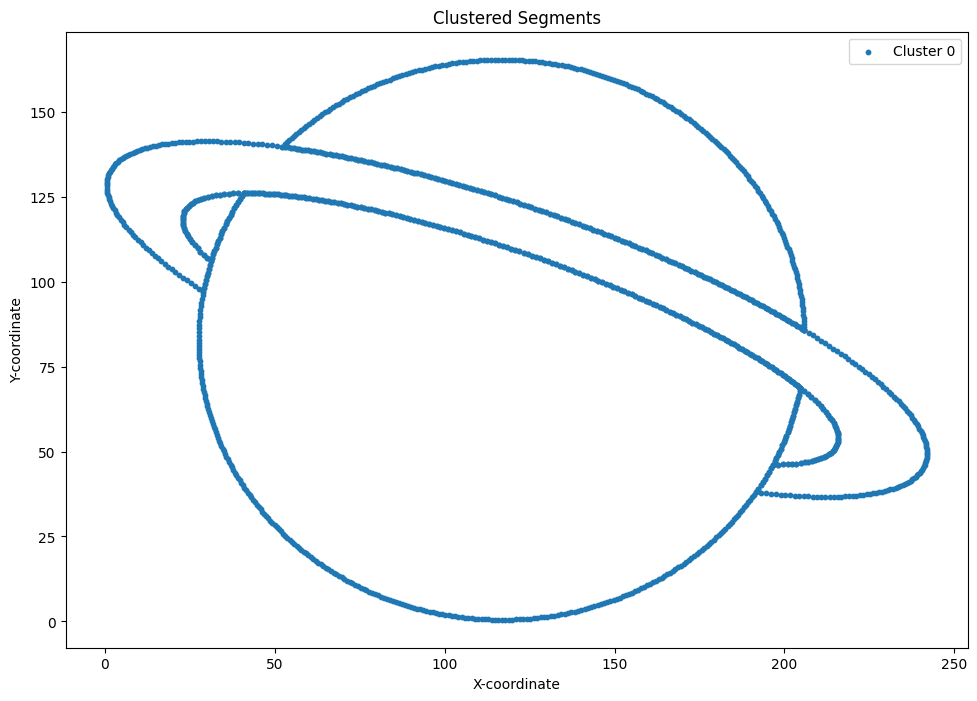

Cluster 0: Segments [0. 1. 2. 3. 4.]


In [23]:
inputd=oc2[['col1','col3','col4']]
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def segment_into_drawings(points_with_segments, eps=5, min_samples=5):
    """
    Segments a set of points into clusters using DBSCAN and identifies segment IDs in each cluster.
    
    Parameters:
        points_with_segments (numpy.ndarray): Array containing segment IDs, x, and y coordinates.
        eps (float): The maximum distance between two points for them to be considered as in the same neighborhood.
        min_samples (int): The number of points in a neighborhood for a point to be considered as a core point.
    
    Returns:
        dict: A dictionary where the key is the cluster label and the value is a list of unique segment IDs in that cluster.
    """
    segment_ids = points_with_segments[:, 0]
    points = points_with_segments[:, 1:]  # Extract x and y coordinates
    
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    cluster_segments_info = {}
    
    plt.figure(figsize=(12, 8))
    
    for label in unique_labels:
        if label == -1:
            continue  # Ignore noise
        
        cluster_mask = (labels == label)
        cluster_points = points_with_segments[cluster_mask]
        
        # Plot the cluster points
        plt.scatter(cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {label}', s=10)
        
        # Extract unique segment IDs in the cluster
        unique_segments = np.unique(cluster_points[:, 0])
        cluster_segments_info[label] = unique_segments
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Clustered Segments')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend(loc='best')
    plt.show()
    
    return cluster_segments_info

# Example usage:

# Assume `f2` is your DataFrame containing 'segment_id', 'col3' (x), and 'col4' (y)
# Convert it to a numpy array with segment ID, x, and y coordinates
points_with_segments = np.array(inputd)

# Segment the points into clusters and extract the segment information
cluster_segments_info = segment_into_drawings(points_with_segments, eps=5, min_samples=5)

# Print the segments in each cluster
for cluster_label, segments in cluster_segments_info.items():
    print(f"Cluster {cluster_label}: Segments {segments}")
allclu=[]
for cluster in cluster_segments_info:
    clus=[]
    for val in cluster_segments_info[cluster]:
        points=np.array(oc2[oc2['col1']==val][['col3','col4']])
        clus.append(points)
    allclu.append(clus) 

/tmp/ipykernel_33/4126224321.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  cost_matrix[i][j][0] = abs(c1_end - c2_start) / (len1 + len2)  # Normal to normal
/tmp/ipykernel_33/4126224321.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  cost_matrix[i][j][1] = abs(c1_start - c2_start) / (len1 + len2)  # Reversed s1 to normal s2
/tmp/ipykernel_33/4126224321.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  cost_matrix[i][j][2] = abs(c1_end - c2_end) / (len1 + len2)  # Normal s1 to reversed s2
/tmp/ipykernel_33/4126224321.py:169: RuntimeWarning: divide by zero encountered in scalar divide
  cost_matrix[i][j][3] = abs(c1_start - c2_end) / (len1 + len2)  # Reversed s1 to reversed s2


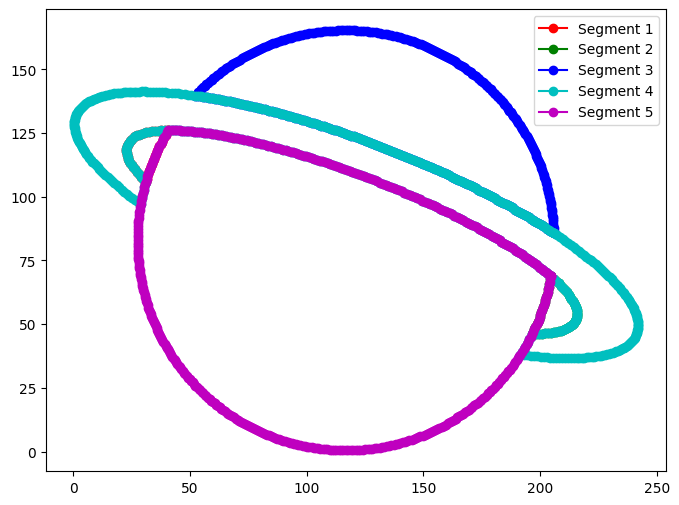

Best Sequence: [0, 1, 3, 4, 2]
Best Orientations: [3, 0, 0, 1]


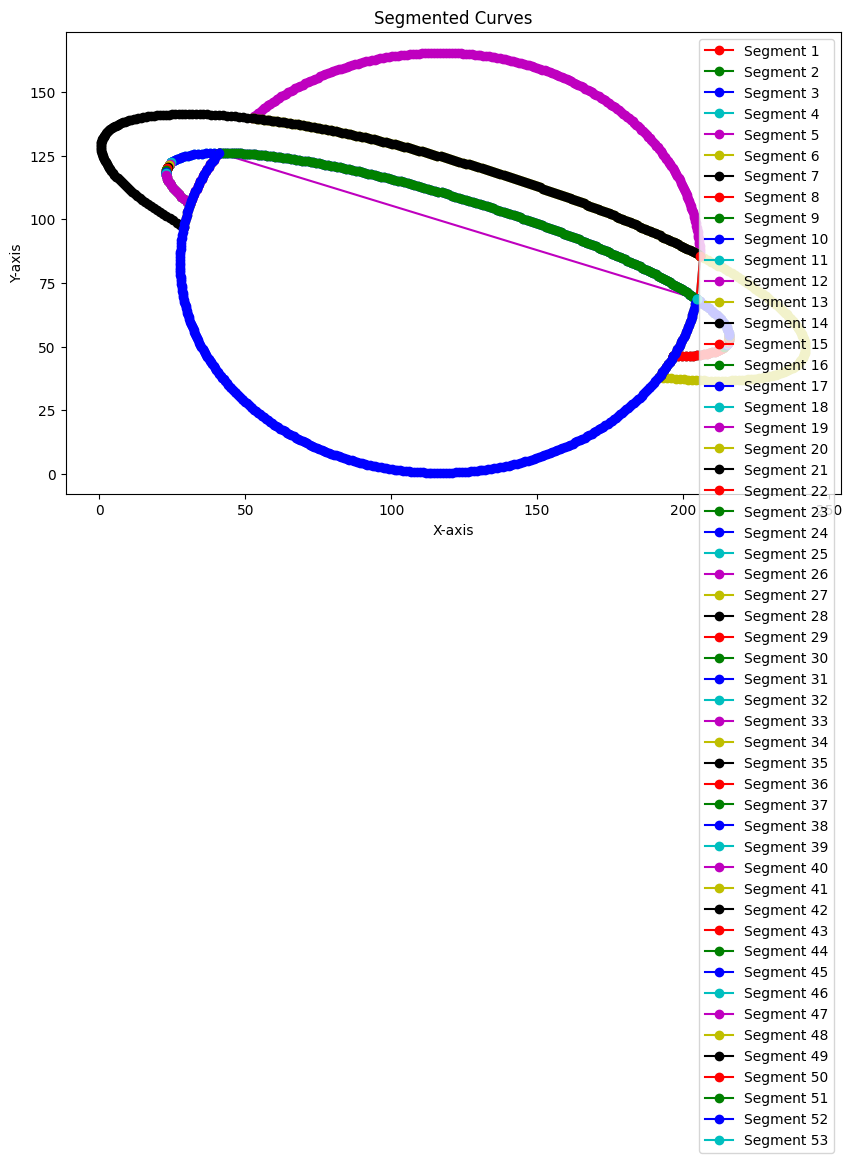

[array([[ 40.83200073, 126.12999725],
        [ 40.24507904, 125.23777008],
        [ 39.67008972, 124.33827209],
        [ 39.10713196, 123.43160248],
        [ 38.55630112, 122.51783752],
        [ 38.01769638, 121.59706116],
        [ 37.49141693, 120.6693573 ],
        [ 36.97755432, 119.7348175 ],
        [ 36.47621155, 118.79351044],
        [ 35.98748016, 117.84554291],
        [ 35.51146317, 116.89097595],
        [ 35.04825211, 115.92990875],
        [ 34.59794617, 114.9624176 ],
        [ 34.16064453, 113.98859406],
        [ 33.73644257, 113.00852203],
        [ 33.32543945, 112.02227783],
        [ 32.92773056, 111.02994537],
        [ 32.54341125, 110.03161621],
        [ 32.17258453, 109.02737427],
        [ 31.81534004, 108.01730347],
        [ 31.47177887, 107.0014801 ],
        [ 31.1420002 , 105.98000336]]),
 array([[ 31.1420002 , 105.98000336],
        [ 30.0632267 , 106.95909119],
        [ 29.05472565, 107.92298126],
        [ 28.11763   , 108.87099457],
        [ 

In [24]:
tspsegment(allclu[0])

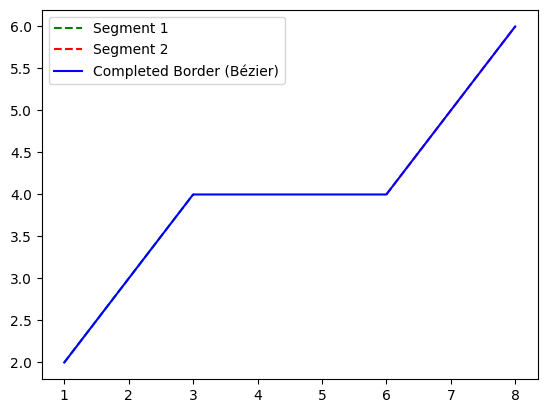

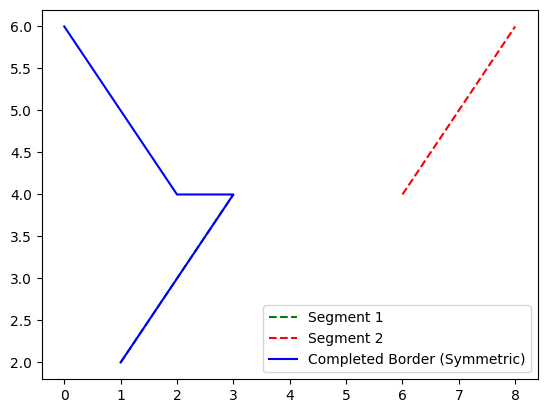

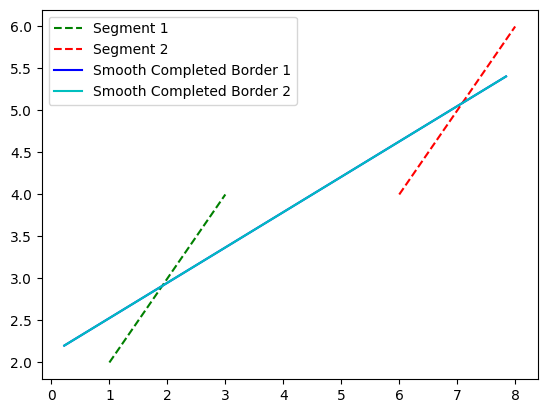

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline

def bezier_curve(t, P0, P1, P2, P3):
    """Compute the cubic Bézier curve."""
    return ((1-t)**3 * P0 +
            3 * (1-t)**2 * t * P1 +
            3 * (1-t) * t**2 * P2 +
            t**3 * P3)

def fit_bezier_curve(points):
    """Fit a cubic Bézier curve to the given points."""
    def cost(params):
        P0 = np.array(params[0:2])
        P1 = np.array(params[2:4])
        P2 = np.array(params[4:6])
        P3 = np.array(params[6:8])
        t = np.linspace(0, 1, len(points))
        curve = np.array([bezier_curve(ti, P0, P1, P2, P3) for ti in t])
        return np.sum((curve - points)**2)

    initial_params = np.concatenate([points[0], points[-1], np.mean(points, axis=0), np.mean(points, axis=0)])
    result = minimize(cost, initial_params, method='L-BFGS-B')
    P = np.array(result.x).reshape(4, 2)
    return P

def reflect_points(points, axis_point, axis_direction):
    """Reflect points across a symmetry axis."""
    reflected_points = []
    for point in points:
        vector = point - axis_point
        projection = np.dot(vector, axis_direction) * axis_direction
        reflected_point = 2 * projection - vector + axis_point
        reflected_points.append(reflected_point)
    return np.array(reflected_points)

def complete_border_bezier(segment1, segment2):
    """Complete the border using Bézier curves."""
    P1 = fit_bezier_curve(segment1)
    P2 = fit_bezier_curve(segment2)

    t = np.linspace(0, 1, 100)
    curve1 = np.array([bezier_curve(ti, *P1) for ti in t])
    curve2 = np.array([bezier_curve(ti, *P2) for ti in t])
    
    connection_curve_x = np.linspace(segment1[-1, 0], segment2[0, 0], 100)
    connection_curve_y = np.linspace(segment1[-1, 1], segment2[0, 1], 100)
    
    completed_border_x = np.concatenate([curve1[:, 0], connection_curve_x, curve2[:, 0]])
    completed_border_y = np.concatenate([curve1[:, 1], connection_curve_y, curve2[:, 1]])
    
    return completed_border_x, completed_border_y

def complete_border_symmetry(segment1, segment2, center, axis_direction):
    """Complete the border using symmetry."""
    reflected_segment2 = reflect_points(segment2, center, axis_direction)
    P1 = fit_bezier_curve(segment1)
    P2 = fit_bezier_curve(reflected_segment2)
    
    t = np.linspace(0, 1, 100)
    curve1 = np.array([bezier_curve(ti, *P1) for ti in t])
    curve2 = np.array([bezier_curve(ti, *P2) for ti in t])
    
    connection_curve_x = np.linspace(segment1[-1, 0], reflected_segment2[0, 0], 100)
    connection_curve_y = np.linspace(segment1[-1, 1], reflected_segment2[0, 1], 100)
    
    completed_border_x = np.concatenate([curve1[:, 0], connection_curve_x, curve2[:, 0]])
    completed_border_y = np.concatenate([curve1[:, 1], connection_curve_y, curve2[:, 1]])
    
    return completed_border_x, completed_border_y

def smooth_border_completion(segment1, segment2):
    """Optimize the completion of the border for smoothness."""
    def objective(params):
        t = np.linspace(0, 1, 100)
        P0 = params[0:2]
        P1 = params[2:4]
        P2 = params[4:6]
        P3 = params[6:8]
        
        curve1 = np.array([bezier_curve(ti, P0, P1, P2, P3) for ti in t])
        curve2 = np.array([bezier_curve(ti, P0, P1, P2, P3) for ti in t])
        
        curvature = np.diff(np.arctan2(np.diff(curve1[:, 1]), np.diff(curve1[:, 0])))
        return np.sum(curvature**2)
    
    initial_params = np.concatenate([segment1[0], segment2[-1], np.mean(segment1, axis=0), np.mean(segment2, axis=0)])
    result = minimize(objective, initial_params, method='L-BFGS-B')
    P = np.array(result.x).reshape(4, 2)
    
    t = np.linspace(0, 1, 100)
    curve1 = np.array([bezier_curve(ti, *P) for ti in t])
    curve2 = np.array([bezier_curve(ti, *P) for ti in t])
    
    return curve1, curve2

# Example usage
segment1 = np.array([[1, 2], [2, 3], [3, 4]])
segment2 = np.array([[6, 4], [7, 5], [8, 6]])

# Complete the border with Bézier curves
completed_x, completed_y = complete_border_bezier(segment1, segment2)

# Visualization for Bézier completion
plt.plot(segment1[:, 0], segment1[:, 1], 'g--', label='Segment 1')
plt.plot(segment2[:, 0], segment2[:, 1], 'r--', label='Segment 2')
plt.plot(completed_x, completed_y, 'b-', label='Completed Border (Bézier)')
plt.legend()
plt.show()

# Example usage with symmetry
center = np.array([4, 3])
axis_direction = np.array([0, 1])  # Vertical axis

completed_x_symmetry, completed_y_symmetry = complete_border_symmetry(segment1, segment2, center, axis_direction)

# Visualization for Symmetry completion
plt.plot(segment1[:, 0], segment1[:, 1], 'g--', label='Segment 1')
plt.plot(segment2[:, 0], segment2[:, 1], 'r--', label='Segment 2')
plt.plot(completed_x_symmetry, completed_y_symmetry, 'b-', label='Completed Border (Symmetric)')
plt.legend()
plt.show()

# Example usage for smooth completion
smooth_curve1, smooth_curve2 = smooth_border_completion(segment1, segment2)

# Visualization for Smooth completion
plt.plot(segment1[:, 0], segment1[:, 1], 'g--', label='Segment 1')
plt.plot(segment2[:, 0], segment2[:, 1], 'r--', label='Segment 2')
plt.plot(smooth_curve1[:, 0], smooth_curve1[:, 1], 'b-', label='Smooth Completed Border 1')
plt.plot(smooth_curve2[:, 0], smooth_curve2[:, 1], 'c-', label='Smooth Completed Border 2')
plt.legend()
plt.show()


In [35]:
  def curvesegment(segments):     
        def compute_curvature(segment):
            if len(segment) < 3:
                return [0] * len(segment)
            curvatures = []
            for i in range(1, len(segment) - 1):
                p1, p2, p3 = segment[i-1], segment[i], segment[i+1]
                ba = p1 - p2
                bc = p3 - p2
                cross_product = np.cross(ba, bc)
                norm_ba = np.linalg.norm(ba)
                norm_bc = np.linalg.norm(bc)
                curvature = np.linalg.norm(cross_product) / (norm_ba * norm_bc) if (norm_ba * norm_bc) != 0 else 0
                curvatures.append(curvature)
            return [0] + curvatures + [0]

        def segment_curves_by_curvature(points, curvature_threshold):
            curvatures = compute_curvature(points)
            segments = []
            start_idx = 0

            for i in range(1, len(curvatures)):
                if abs(curvatures[i]) > curvature_threshold:
                    segments.append(points[start_idx:i+1])
                    start_idx = i

            if start_idx < len(points):
                segments.append(points[start_idx:])

            return segments

        def visualize_segments(segments):
            plt.figure(figsize=(10, 6))
            colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Use different colors for different segments

            for i, segment in enumerate(segments):
                color = colors[i % len(colors)]
                plt.plot(segment[:, 0], segment[:, 1], color=color, marker='o', label=f'Segment {i+1}')

            plt.title("Segmented Curves")
            plt.xlabel("X-axis")
            plt.ylabel("Y-axis")
            plt.legend()
            plt.show()
        curvature_threshold = 0.9

# Segment curves based on curvature
        segmentsf = segment_curves_by_curvature(reshape_segments_to_points(segments), curvature_threshold)
        print(segmentsf)
        # Visualize the segmented curves
        visualize_segments(segmentsf)
        return segmentsf
